In [1]:
#@title Library and Environment
import pandas as pd
import fmpsdk
import os
import dotenv

dotenv.load_dotenv()
apikey:str=os.getenv("apikey")
stock_symbol: str = input("Please enter stock symbol: ")

In [2]:
#@title JSON data
keymetrics_data:list[dict]=fmpsdk.key_metrics(apikey,symbol=stock_symbol)
keymetrics_data.reverse()
ratio_data:list[dict]=fmpsdk.financial_ratios(apikey,symbol=stock_symbol,period='annual')
ratio_data.reverse()
balance_data:list[dict]=fmpsdk.balance_sheet_statement(apikey,symbol=stock_symbol,period='annual')
balance_data.reverse()
income_data:list[dict]=fmpsdk.income_statement(apikey,symbol=stock_symbol,period='annual')
income_data.reverse()

In [3]:
balance_frame=pd.DataFrame(balance_data,columns=["calendarYear",'totalStockholdersEquity',"totalDebt","totalStockholdersEquity"])
balance_frame=balance_frame.set_index(keys=['calendarYear'])
balance_frame

,totalStockholdersEquity,totalDebt,totalStockholdersEquity
calendarYear,,,
2020,33665984000,13900346000,33665984000
2021,37176551000,13779547000,37176551000
2022,41620774000,15204761000,41620774000
2023,44945348000,12247137000,44945348000
2024,54212922000,13381952000,54212922000


In [4]:
income_frame = pd.DataFrame(income_data,columns=['calendarYear','netIncome','eps'])
income_frame=income_frame.set_index(keys=['calendarYear'])


In [5]:

ratio_frame=pd.DataFrame(ratio_data,columns=['calendarYear',"debtEquityRatio","currentRatio"])
ratio_frame.set_index(keys=["calendarYear"])
ratio_frame

,calendarYear,debtEquityRatio,currentRatio
0,2020,0.412890,2.788510
1,2021,0.370652,3.051268
2,2022,0.365317,3.249507
3,2023,0.272490,3.880737
4,2024,0.246841,4.358075


<!-- @title Vigilant leader -->
## Vigilant leader

### Rule 1 - importance of `debtEquityRatio`
A  company can choose to finance its investment using its equity or debt. However, a company would have much better flexibility if it use equity. Warren Buffet like to invest in company whose `debtEquity` ratio is below `0.5`

### Rule 2 - current ratio

**Current Asset** will be converted to cash within the next 12 months such the inventory expected to be sold. On the other hand, **Current Liability** is the money that company will need to pay within next 12 months, so it could be raw material received from the supplier but they have not paid for it. `Current ratio = current asset / current liability`. Really high current ratio can indicate that the company having hardtime collecting money from the vender. If current ratio below 1, the company might have to acquire new debt to pay off the existing debt. In general, current ratio between 1.5 to 2.5 is desireable. A current ratio above 5 might indicate bad money mannagement.

### Rule 3 - Strong and consistent return on equity

ROE shows you how effective the mangement reinvest your profit in the business. `ROE = Net Income / Shareholder's Equity` Remember that `equity = asset - libility`, and all profit made will go under `equity` in the balance sheet, so ROE help us examine portion of equity that is net income. In general, we should look for companies that have a consistent ROE above `8%` over the last ten 10 years. After identifying the trend, we should also compare it with the competitor. When examing ROE, it is very important to compare it side by side with debt to equity ratio. The company can potentially use debt instead of its stockholder's equity to keep ROE consistent or even higher, so we need to be careful of company with `debtEquity ratio` higher than 0.5. Here is an example demonstrating such account tricks

![ROE accounting tricks](https://i.ibb.co/twfwHZg7/roe-accounting-tricks.png)

In the picture above, we see the company using debt instead of shareholder's equity to make ROE look nicer.

### Rule 4 - Appropriate management incentives

If a management is given the incentive to solely focus on the share price, the management is also given the incentive not to pay out dividends, but rather to retain all earnings even though there are no good projects to invest in.
You want a company that disclose how much the base salary is and how much is variable, and which indicators the management is measured on.





,debtToEquity,currentRatio,bookValuePerShare,roe
calendarYear,,,,
2020,0.412890,2.788510,138.977353,0.058585
2021,0.370652,3.051268,152.566853,0.160955
2022,0.365317,3.249507,163.385389,0.239941
2023,0.272490,3.880737,171.958644,0.227025
2024,0.246841,4.358075,205.375417,0.249967


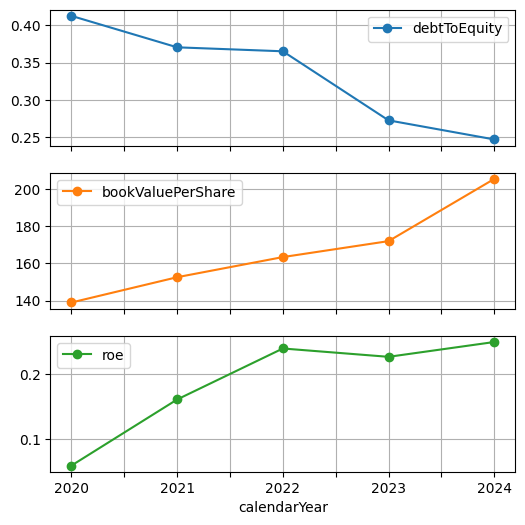

In [7]:
#@title table for vigilant leader

keymetric_frame=pd.DataFrame(keymetrics_data,columns=['calendarYear','debtToEquity','currentRatio','bookValuePerShare','roe'])
keymetric_frame=keymetric_frame.set_index(keys=['calendarYear'])
keymetric_frame.plot(use_index=True,y=['debtToEquity','bookValuePerShare','roe'],subplots=True,marker="o",grid=True,figsize=(6,6))
keymetric_frame

## Principle 2 - A company must have long-term prospect

### Rule 1 - persistent products
After 30 years, it is unlikely that consumer will not change the way they smartphone today. Warren Buffet use this question to determine whether or not he invest in a company: **"Will the Internet change the way we use the product?"**

### Rule 2 - minimize tax

A country often encourage long-term investment. You would have to pay tax on your capital gain like the ordinary income. If you hold onto an investment for more than one year, the rate is usually fixed.



## Priciple 3 - A company must be stable and understandable

### Rule 1 - stable book value growth from the owner's earning
We should look at the stability and growth of book value and earnings per share.It shows that book value growth comes from earnings. When there is increase in equity, there must be an increase in asset or decrease in liability. Dividend paid can reduce equity.

In general, we will see growth in EPS and book value per share, which would reflect in stable ROE value. Since dividend can reduce equity, we should also try to fit dividend into the trend line.


,netIncomePerShare,bookValuePerShare,roe
calendarYear,,,
2020,6.574397,138.977353,0.058585
2021,19.945823,152.566853,0.160955
2022,33.288500,163.385389,0.239941
2023,34.010000,171.958644,0.227025
2024,45.171430,205.375417,0.249967


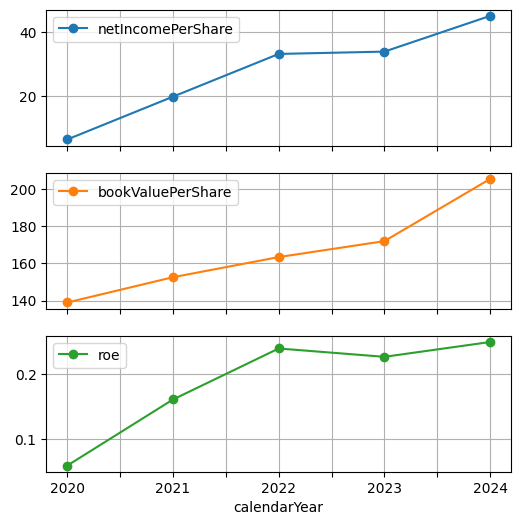

In [8]:
#@title Principle 3 code
keymetric_frame=pd.DataFrame(keymetrics_data,columns=["calendarYear",'netIncomePerShare','bookValuePerShare','roe'])
keymetric_frame=keymetric_frame.set_index(keys=["calendarYear"])
keymetric_frame.plot(subplots=True,marker="o",grid=True,figsize=(6,6))
# keymetric_figure=plt.figure()
# keymetric_figure.subplots_adjust(hspace=0.5,wspace=0.5)
# bv_ax=keymetric_figure.add_subplot(2,2,1)
# bv_ax.plot(keymetric_frame['calendarYear'],keymetric_frame['bookValuePerShare'],marker="o")
# bv_ax.set_title('Book value per share')
# ep_ax=keymetric_figure.add_subplot(2,2,3)
# ep_ax.plot(keymetric_frame['calendarYear'],keymetric_frame['netIncomePerShare'],marker="o")
# ep_ax.set_title('Net income per share')
# roe_ax=keymetric_figure.add_subplot(2,2,2)
# roe_ax.plot(keymetric_frame['calendarYear'], keymetric_frame['roe'],marker="o")
# roe_ax.set_title('Return on Equity')
keymetric_frame



## Priciple 4 -Buy at attractive prices

### Rule 1 - margin of safety

The margin of safety is the difference between the share price and the intrinsic value.

### Rule 2 - Low price-earning ratio

`PE ratio = market price of the company / net income`. Warren Buffet suggests that you buy stock with PE below 15. Estimated earning can dramatically change forward PE ratio, so we should also monitor the stability of earning.

### Rule 3 - low price-to-book ratio

`Price to book ratio = market of the company per share / equity per share`. This ratio measure how much investor pay for every $1 of company's equity. Benjamin Graham would try to find companies that had a P/B ratio below 1.5.

### Rule 4 - set a safe discount rate
By using discount rate, an investor can take a business's estimated future cash flows and discount them back to today's value. If a ten-year bond has a 3% return, the investor should never discount a ten-year investment lower than 3% annually. Discount rate are based on opportunity cost, because there might be other investment opportunities that could produce larger return with less risk.

In [9]:
# util function
def to_percentage(num:float)->str:
  return f'{num*100:.2f} %'

,revenue,grossProfitRatio,operatingIncomeRatio,netIncomeRatio,operatingIncome,interestExpense,costOfRevenue,Interest Coverage ratio
calendarYear,,,,,,,,
2020,12624731000,47.52 %,25.95 %,15.62 %,3276176000,926312000,6625659000,3.536795
2021,18784661000,65.25 %,46.09 %,31.85 %,8657674000,842386000,6527886000,10.277562
2022,25313882000,74.13 %,58.06 %,39.45 %,14698149000,855518000,6547710000,17.180409
2023,25821644000,60.27 %,59.03 %,39.52 %,15243525000,1125862000,10258919000,13.539426
2024,31332787000,64.35 %,55.92 %,43.25 %,17519806000,826708000,11170359000,21.192254


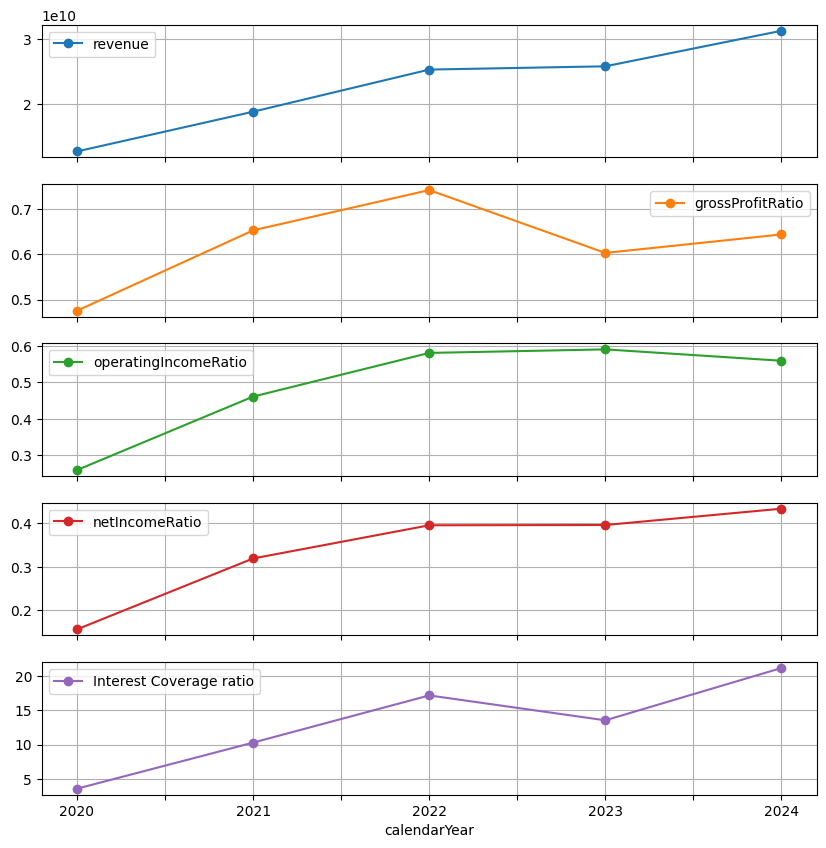

In [10]:
#@title Income Ratio analysis
income_columns:list[str]=['calendarYear','revenue','grossProfitRatio','operatingIncomeRatio','netIncomeRatio','operatingIncome',"interestExpense","costOfRevenue"]
income_frame = pd.DataFrame(income_data, columns=income_columns)
income_frame=income_frame.set_index(keys=['calendarYear'])
# calculate ratio
income_frame['Interest Coverage ratio'] = income_frame['operatingIncome'] / income_frame["interestExpense"]
income_frame.plot(use_index=True,y=['revenue','grossProfitRatio','operatingIncomeRatio','netIncomeRatio','Interest Coverage ratio'],subplots=True,marker="o",grid=True,figsize=(10,10))

# convert ratio to formated string
income_frame['grossProfitRatio'] = income_frame['grossProfitRatio'].map(to_percentage)
income_frame['operatingIncomeRatio'] =income_frame['operatingIncomeRatio'].map(to_percentage)
income_frame['netIncomeRatio'] = income_frame['netIncomeRatio'].map(to_percentage)


income_frame

|                         	| Formula                             	| Note                                                                                                                                                                                                                    	|
|-------------------------	|-------------------------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Gross profit margin     	| gross profit / revenue              	| This ratio tells us how efficient  the company is at controlling their direct cost                                                                                                                                      	|
| Operating income ratio  	| operating income / revenue          	| compared to gross profit margin, this ratio take into the secondary expense such as administration, marketing, distribution                                                                                             	|
| Net income ratio        	| Net income / revenue                	| When looking at this ratio, this is  the money that the investors made  compared to money the business collected for the sale of every product                                                                          	|
| Interest Coverage ratio 	| operating income / interest expense 	| This is very important ratio for minimizing your risk. It shows company's ability to keep its head above water. As a rule of thumb, the ratio need to be consistently above 5 for a company to be considered as stable. 	|


In [ ]:
#@title Balance sheet ratio
balance_columns:list[str]=["calendarYear","totalCurrentAssets","inventory","totalCurrentLiabilities"]
balance_frame = pd.DataFrame(data=balance_data,columns=balance_columns)
balance_frame = balance_frame.set_index(keys=["calendarYear"],drop=True)

# liquidity ratio
ratio_columns:list[str]=["calendarYear","inventoryTurnover","receivablesTurnover","payablesTurnover"]
ratio_frame=pd.DataFrame(ratio_data,columns=ratio_columns)
ratio_frame["days of collecting payment"] = 365 / ratio_frame['receivablesTurnover']
ratio_frame["days of repaying supplier"] = 365 / ratio_frame['payablesTurnover']
ratio_frame = ratio_frame.set_index(keys=["calendarYear"],drop=True)
balance_ratios=balance_frame.join(ratio_frame)


balance_ratios

,totalCurrentAssets,inventory,totalCurrentLiabilities,inventoryTurnover,receivablesTurnover,payablesTurnover,days of collecting payment,days of repaying supplier
calendarYear,,,,,,,,
2020,7716049000,34023000,2767087000,194.740587,9.295008,18.722633,39.268390,19.495121
2021,11553314000,57101000,3786398000,114.321746,10.001214,22.456752,36.495568,16.253463
2022,18080170000,64716000,5563973000,101.176062,9.958556,21.323323,36.651901,17.117407
2023,18733197000,60360000,4827227000,169.962210,11.140497,33.466056,32.763350,10.906574
2024,26130599000,0,6361594000,231.764737,10.034240,29.004968,36.375451,12.584051
